![title](../images/header.png)

Drivers analysis 2015-2023
-------
This notebook merges all validated data from different CEO CAFI projects for all years and determines the relative driver contribution
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Set the display option to a large value to prevent text wrapping
pd.set_option('display.max_colwidth', None)

### 1. Read all CEO sample files
download your CEO sample files from collect.earth and upload to SEPAL using FileZilla.
add as many files as you have projects

In [2]:
ceo1 = pd.read_csv('/home/sepal-user/module_results/esbae/CAR/CAR_all_ceo_2015_2022_2023_TNTstrat.csv',low_memory=False)
ceo2 = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_all_ceo_2015_2022_2023_TNTstrat.csv',low_memory=False)
ceo3 = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_all_ceo_1522_1622_clean.csv',low_memory=False)
ceo4 = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_all_ceo_2015_2022_2023_TNTstrat.csv',low_memory=False)
ceo5 = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_all_ceo_2015_2022_2023_TNTstrat.csv',low_memory=False)
ceo6 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_all_ceo_2015_2022_2023_TNTstrat.csv',low_memory=False)

In [3]:
output_drivers = '/home/sepal-user/module_results/esbae/CAFI/CAFI_all_ceo_drivers.csv'

In [4]:
# Concatenate DataFrames
combined_ceo = pd.concat([ceo1, ceo2, ceo3, ceo4, ceo5, ceo6], axis=0, ignore_index=True)

In [5]:
len(combined_ceo)

49975

In [6]:
pd.pivot_table(combined_ceo,values='point_id',index=['ISO'],columns=['Ref_FNF_2015'],aggfunc="count",margins=True,
                             margins_name='Total')

Ref_FNF_2015,0.0,1.0,Total
ISO,,,
CAF,2770,1607,4377
CMR,3068,3665,6733
COD,6297,6850,13147
COG,143,260,403
EQG,879,3603,4482
GAB,1364,6963,8327
Total,14521,22948,37469


In [7]:
print(combined_ceo.dtypes)

geometry                   object
UID                       float64
TNT_stratum_1522          float64
TNT_stratum_2223          float64
ID                        float64
plotid                      int64
point_id                  float64
sampleid                    int64
lon                       float64
lat                       float64
Ref_FNF_2015              float64
Ref_Regeneration           object
Ref_Change_1522           float64
Ref_Change_Type_1522       object
ArtFor                    float64
ArtMine                   float64
InfraR                    float64
Urb                       float64
IndFor                    float64
Other                     float64
Other_Desc                 object
IndMine                   float64
IndAg                     float64
ArtAg                     float64
Ref_Year_1522             float64
Ref_NFtype_2015           float64
Ref_Ftype_2015            float64
collection                 object
interpreted                 int64
Ref_LCover_201

In [8]:
combined_ceo['CountDrivers'] = combined_ceo[['ArtFor','ArtMine',
                                             'InfraR','Urb','IndFor','Other',
                                             'IndMine','IndAg','ArtAg']].sum(axis=1)

In [9]:
combined_ceo['CountDrivers'].value_counts(dropna=False)

CountDrivers
0.0    47377
1.0     1460
2.0      636
3.0      279
4.0      205
5.0       16
7.0        1
6.0        1
Name: count, dtype: int64

In [10]:
combined_ceo['IndDrivers'] = (combined_ceo['IndAg'] == 1) | (combined_ceo['IndFor'] == 1) | (combined_ceo['IndMine'] == 1)
combined_ceo['IndDrivers'].value_counts(dropna=False)

IndDrivers
False    49737
True       238
Name: count, dtype: int64

In [11]:
# Function to determine 'GroupedDrivers'
def determine_grouped_drivers(row):
    if row['CountDrivers'] == 0:
        return ""
    elif row['ArtMine'] == 1 and row['IndDrivers'] == "False":
        return "artisanal mining"
    elif row['ArtMine'] == 1 and row['CountDrivers'] <= 2:
        return "artisanal mining"
    elif row['IndMine'] == 1:
        return "industrial mining"
    elif row['IndAg'] == 1 and row['IndFor'] == 1 and row['IndMine'] == 0:
        return "industrial forestry and agriculture"
    elif row['IndFor'] == 1 and row['IndAg'] == 0 and row['IndMine'] == 0:
        return "industrial forestry"
    elif row['IndAg'] == 1 and row['IndFor'] == 0 and row['IndMine'] == 0:
        return "industrial agriculture"
    elif row['ArtFor'] == 1 and row['ArtAg'] == 0 and row['ArtMine'] == 0 and row['IndDrivers'] == "False":
        return "artisanal forestry"
    elif row['ArtAg'] == 1 and row['InfraR'] == 1 and row['CountDrivers'] <= 2 and row['ArtMine'] == 0:
        return "infrastructure agriculture"
    elif row['CountDrivers'] <= 2 and row['ArtAg'] == 0 and (row['InfraR'] == 1 or row['Urb'] == 1) and row['IndDrivers'] == "False":
        return "human infrastructure"
    elif row['ArtFor'] == 1 and row['CountDrivers'] == 1:
        return "artisanal forestry"
    elif row['CountDrivers'] == 1 and row['Other'] == 1:
        return "other"
    else:
        return "rural complex"

# Apply the function to create the new column
combined_ceo['GroupedDrivers'] = combined_ceo.apply(determine_grouped_drivers, axis=1)

In [12]:
combined_ceo['GroupedDrivers'].value_counts(dropna=False)

GroupedDrivers
                                       47377
rural complex                           2010
artisanal forestry                       231
industrial forestry                      136
industrial agriculture                    80
infrastructure agriculture                61
other                                     40
industrial mining                         19
artisanal mining                          18
industrial forestry and agriculture        3
Name: count, dtype: int64

In [13]:
# Group by 'CountDrivers' and 'Ref_Change_Bin', then count the occurrences
count_table = combined_ceo.groupby(['Ref_Change_Type','CountDrivers',]).size().reset_index(name='Row_Count')
print(count_table)

  Ref_Change_Type  CountDrivers  Row_Count
0             Def           0.0         47
1             Def           1.0          2
2             Def           2.0          5
3             Def           3.0          2
4             Deg           0.0         86
5             Deg           1.0          1
6              NF           0.0       1453
7          Stable           0.0       1622


In [14]:
# Filter the DataFrame based on the conditions
filtered_df = combined_ceo[(combined_ceo['CountDrivers'] == 0) & (combined_ceo['Ref_Change_Type'].isin(['Def', 'Deg']))]
# Display the resulting DataFrame
filtered_df.head()

,geometry,UID,TNT_stratum_1522,TNT_stratum_2223,ID,plotid,point_id,sampleid,lon,lat,Ref_FNF_2015,Ref_Regeneration,Ref_Change_1522,Ref_Change_Type_1522,ArtFor,ArtMine,InfraR,Urb,IndFor,Other,Other_Desc,IndMine,IndAg,ArtAg,Ref_Year_1522,Ref_NFtype_2015,Ref_Ftype_2015,collection,interpreted,Ref_LCover_2015,Ref_Change_Year_1522,Ref_Change_LCover_1522,Def2016,Def2017,Def2018,Def2019,Def2020,Def2021,Def2022,Deg2016,Deg2017,Deg2018,Deg2019,Deg2020,Deg2021,Deg2022,Defall,Degall,Stable,NF,DensFor,DensDryFor,SecFor,DryOpenFor,Mangrove,Swamp,Gallery,Plantation,Woodland,Shrubland,Grassland,Aquatic,Bare,Cultivated,Builtup,Water,DensFor_Def,DensDryFor_Def,SecFor_Def,DryOpenFor_Def,Mangrove_Def,Swamp_Def,Gallery_Def,Plantation_Def,Woodland_Def,DensFor_Deg,DensDryFor_Deg,SecFor_Deg,DryOpenFor_Deg,Mangrove_Deg,Swamp_Deg,Gallery_Deg,Plantation_Deg,Woodland_Deg,DensFor_Stable,DensDryFor_Stable,SecFor_Stable,DryOpenFor_Stable,Mangrove_Stable,Swamp_Stable,Gallery_Stable,Plantation_Stable,Woodland_Stable,ISO,sampling,Ref_FNF_2022,Ref_Change_2023,Ref_Change_Type_2023,Ref_NFtype_2022,Ref_Ftype_2022,Ref_LCover_2022,Ref_Change_Year_2023,Ref_Change_LCover_2023,Def2023,Deg2023,interpreted_qc,Ref_Change_Type_1523,Ref_Change_Year_1523,Prefecture,Province,index,sample_geom,Ref_FNF_2016,Ref_Change_1622,Ref_Change_Type_1622,Ref_NFtype_2016,Ref_Ftype_2016,Ref_Year_1622,Ref_LCover,Ref_Change_Year_1622,Source,Ref_Change_Type,Ref_Change_Bin,Ref_NFtype,Ref_Ftype,Ref_Change_Year,Ref_Year,TNT_stratum_1522_v2,TNT_stratum_2223_v3,TNT_stratum_2223_v2,TNT_stratum,CountDrivers,IndDrivers,GroupedDrivers
15870,NaN,NaN,NaN,NaN,NaN,1062731,1062731.0,1062731,14.678152,-4.138782,NaN,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020.0,NaN,NaN,2,1,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG,systematic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29822.0,POINT(14.67815225155834 -4.138781529271595),1.0,1.0,Def,NaN,3.0,2020.0,3.0,Def2020,COG_1622,Def,1.0,NaN,NaN,Def2020,2020.0,NaN,NaN,NaN,NaN,0.0,False,
15871,NaN,NaN,NaN,NaN,NaN,1048582,1048582.0,1048582,14.515997,-4.455806,NaN,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,NaN,NaN,1,1,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG,systematic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31527.0,POINT(14.515997041749788 -4.455805777767383),1.0,1.0,Def,NaN,3.0,2019.0,3.0,Def2019,COG_1622,Def,1.0,NaN,NaN,Def2019,2019.0,NaN,NaN,NaN,NaN,0.0,False,
15872,NaN,NaN,NaN,NaN,NaN,1068554,1068554.0,1068554,15.585994,-2.020294,NaN,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0,NaN,NaN,2,1,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG,systematic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36218.0,POINT(15.585994012332552 -2.020293832486832),1.0,1.0,Def,NaN,3.0,2021.0,3.0,Def2021,COG_1622,Def,1.0,NaN,NaN,Def2021,2021.0,NaN,NaN,NaN,NaN,0.0,False,
15873,NaN,NaN,NaN,NaN,NaN,1062548,1062548.0,1062548,14.564833,-4.321275,NaN,Non,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0,NaN,NaN,2,1,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COG,systematic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43710.0,POINT(14.564833116487128 -4.32127469898492),1.0,1.0

In [15]:
# Group by 'CountDrivers' and 'Ref_Change_Bin', then count the occurrences
count_table = filtered_df.groupby(['ISO','CountDrivers',]).size().reset_index(name='Row_Count')
print(count_table)

   ISO  CountDrivers  Row_Count
0  COG           0.0        133


In [16]:
filtered_df.to_csv('/home/sepal-user/tmp/no_drivers.csv',index_label='ID')

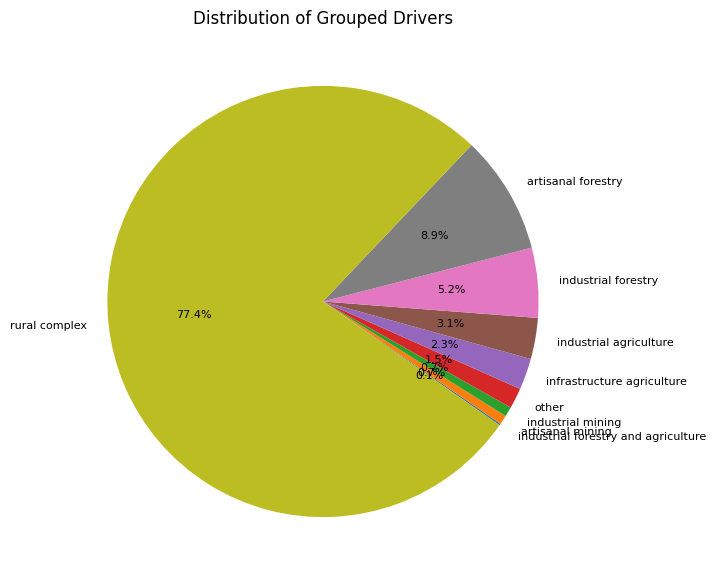

In [17]:
# Filter out blank values
filtered_df = combined_ceo[combined_ceo['GroupedDrivers'] != '']

# Count the occurrences of each value
grouped_counts = filtered_df['GroupedDrivers'].value_counts()

# Sort the counts in descending order
grouped_counts = grouped_counts.sort_values(ascending=True)

# Plot the pie chart with sorted values and smaller text labels
plt.figure(figsize=(10, 7))
plt.pie(
    grouped_counts, 
    labels=grouped_counts.index, 
    autopct='%1.1f%%', 
    startangle=325,
    textprops={'fontsize': 8}  # Adjust the fontsize here
)
# Add a title
plt.title('Distribution of Grouped Drivers')

# Show the plot
plt.show()

In [18]:
print(combined_ceo.dtypes)

geometry                   object
UID                       float64
TNT_stratum_1522          float64
TNT_stratum_2223          float64
ID                        float64
plotid                      int64
point_id                  float64
sampleid                    int64
lon                       float64
lat                       float64
Ref_FNF_2015              float64
Ref_Regeneration           object
Ref_Change_1522           float64
Ref_Change_Type_1522       object
ArtFor                    float64
ArtMine                   float64
InfraR                    float64
Urb                       float64
IndFor                    float64
Other                     float64
Other_Desc                 object
IndMine                   float64
IndAg                     float64
ArtAg                     float64
Ref_Year_1522             float64
Ref_NFtype_2015           float64
Ref_Ftype_2015            float64
collection                 object
interpreted                 int64
Ref_LCover_201

In [19]:
# select columns to extract
columns_to_extract = ['Ref_FNF_2015','Ref_Regeneration','Ref_Change_Year',
'Ref_Change_Type','Ref_LCover','Ref_Year','Ref_NFtype','Ref_Ftype','ArtFor','ArtMine','InfraR','Urb',
'IndFor','IndMine','IndAg','ArtAg','Other','Other_Desc','CountDrivers','GroupedDrivers']

# Extract the specified columns
select_df = combined_ceo[columns_to_extract]

In [20]:
select_df.to_csv(output_drivers,index_label='ID')